# Implementing SGD and Momentum

In this file, we will be looking at Stochastic Gradient Descent and using momentum to speed up the training process.

We'll be looking at classifying different points and seeing how momentum (and mini-batches) can improve the training process.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import dataset
import torch_dataset
import statistics

## Dataset

In [121]:
np.random.seed(79) # To ensure that the dataset doesn't change
ds = torch_dataset.UClasses(n=1000)

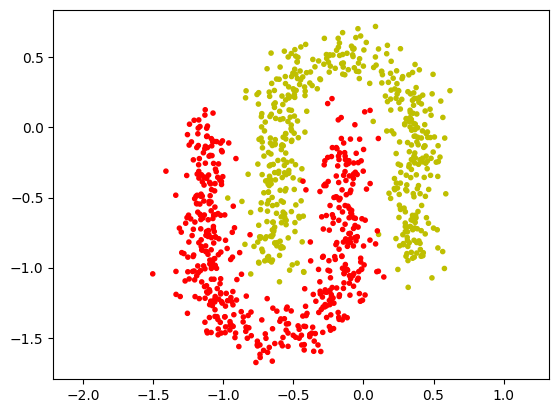

In [122]:
ds.plot()

## Implementing `sgd` with momentum

In [176]:
def sgd(net, dl, loss_func, lrate=0.1, epochs=10, momentum=0.):
    '''
     losses = sgd(net, dl, loss_func, lrate=0.1, epochs=10, momentum=0.)

     Performs learning using stochastic gradient descent (SGD).

     Inputs:
       net        PyTorch nn.Module
       dl         PyTorch DataLoader object
       loss_func  PyTorch loss function
       lrate      learning rate
       epochs     number of epochs to run (max)
                  It stops early if the loss goes below 0.04.
       momentum   momentum parameter, from the range [0, 1)

     Output:
       losses     list of the loss at the end of each epoch
    '''
    losses = []
    # Velocities should be initially defined as all zeros
    velocities = []
    for p in net.parameters():
      v = torch.zeros_like(p)
      velocities.append(v)

    for epoch in range(epochs):
      # Implement looping over batches
      loss_vals = []
      iter_batch = iter(dl)
      while True:
        try:
          x, targets = next(iter_batch)
          y = net(x)
          err = loss_func(y, targets)
          loss_vals.append(err.item())
          net.zero_grad()
          err.backward()
          counter = 0 # to iterate over velocity Tensors
          with torch.no_grad():
            for p in net.parameters():
              velocities[counter] = momentum * velocities[counter] + p.grad
              p -= lrate * velocities[counter]
              #p -= lrate * p.grad
              counter += 1
        except: # Catches the Stop Iteration
          break
      # Append the batch loss to losses (THE MEAN of loss_vals)
      mean_loss = statistics.mean(loss_vals)
      losses.append(mean_loss)

      if mean_loss <= 0.04:
        break;  # Terminates if reaches 0.04 in loss

      dl.reset() # to reset the batch for the next epoch


    return losses

# SGD (one batch, no momentum)

In [202]:
net_orig = nn.Sequential(
        nn.Linear(2,12), # input Layer
        nn.ReLU(),
        nn.Linear(12,7), # Hidden #1
        nn.ReLU(),
        nn.Linear(7,5), # Hidden #2
        nn.LogSoftmax(dim=-1))

lr = 0.09  # choose a learning rate

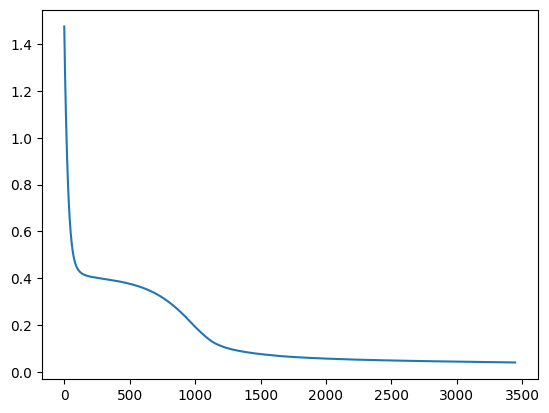

In [203]:
# Create a copy of the network
net = copy.deepcopy(net_orig)

# Train network as a single batch
dl = dataset.MyDataLoader(ds, batchsize=1000)
loss_func = torch.nn.NLLLoss(reduction="mean")
losses = sgd(net, dl, loss_func, lrate=lr, epochs=5000, momentum=0.)
plt.plot(losses)

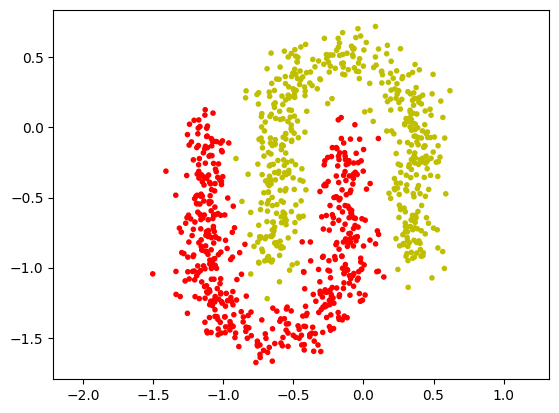

In [204]:
ds.plot(labels=net(ds.inputs()))

# SGD with Mini-Batches and/or Momentum

## SGD with Mini-Batches (but not momentum)

In [205]:
# Copy the original network
net1 = copy.deepcopy(net_orig)
# Train network as a single batch
dl1 = dataset.MyDataLoader(ds, batchsize=100)
loss_func = torch.nn.NLLLoss(reduction="mean")
losses1 = sgd(net1, dl1, loss_func, lrate=lr, epochs=5000, momentum=0.)

## SGD with Momentum (but not mini-batches)

In [206]:
# Copy the original network
net2 = copy.deepcopy(net_orig)
# Train network as a single batch
dl2 = dataset.MyDataLoader(ds, batchsize=1000)
loss_func = torch.nn.NLLLoss(reduction="mean")
losses2 = sgd(net2, dl2, loss_func, lrate=lr, epochs=5000, momentum=0.9)

## SGD with Momentum *and* Mini-Batches

In [207]:
# Copy the original network
net3 = copy.deepcopy(net_orig)
# Train network as a single batch
dl3 = dataset.MyDataLoader(ds, batchsize=100)
loss_func = torch.nn.NLLLoss(reduction="mean")
losses3 = sgd(net3, dl3, loss_func, lrate=lr, epochs=5000, momentum=0.9)

## Plot all the learning curves together

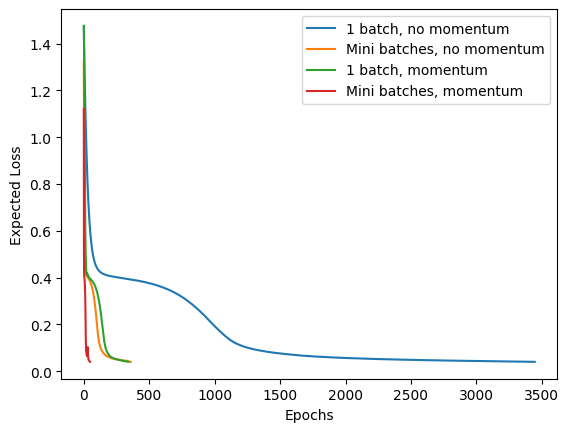

In [209]:
plt.plot(losses, label="1 batch, no momentum")
plt.plot(losses1, label="Mini batches, no momentum")
plt.plot(losses2, label="1 batch, momentum")
plt.plot(losses3, label="Mini batches, momentum")
plt.xlabel("Epochs")
plt.ylabel("Expected Loss")
plt.legend()

We can see there that mini-batches and momentum makes the entire training process go by much faster compared to without both. Even just having one of the methods can dramatically reduce the amount of epochs needed to train the model.